# Reinforcement Learning Trading Bot -- Q Learning Algorithm
- Use the Gymnasium library (based on the Open AI Gym library) to create an environment for the experiment.
- Use the scaffolding from Pytorch tutorials to build a deep Q-learning (DQN) Agent

In [1]:
import os
import math
import random
from collections import namedtuple, deque
from itertools import count
from importlib.machinery import SourceFileLoader
import importlib.util
import sys

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
# from gym.envs.registration import register
import gym_trading_env
from gym_trading_env.downloader import download
from gym_trading_env.renderer import Renderer
import datetime

In [2]:
df_btc_bitfinex = pd.read_pickle('data/bitfinex2-BTCUSDT-1h.pkl')
df_eth_bitfinex = pd.read_pickle('data/bitfinex2-ETHUSDT-1h.pkl')

In [3]:
df_btc_bitfinex.head()

,open,high,low,close,volume,date_close
date_open,,,,,,
2019-03-11 10:00:00,3870.1,3890.0,3870.1,3890.0,0.050000,2019-03-11 11:00:00
2019-03-11 11:00:00,3875.3,3907.7,3875.3,3907.7,1.539235,2019-03-11 12:00:00
2019-03-11 12:00:00,3870.0,3870.0,3870.0,3870.0,0.100000,2019-03-11 13:00:00
2019-03-11 13:00:00,3866.9,3866.9,3865.5,3865.5,0.549000,2019-03-11 14:00:00
2019-03-11 14:00:00,3867.9,3868.0,3857.3,3860.1,5.097256,2019-03-11 15:00:00


In [4]:
df_btc_bitfinex.iloc[:,0]

date_open
2019-03-11 10:00:00     3870.1
2019-03-11 11:00:00     3875.3
2019-03-11 12:00:00     3870.0
2019-03-11 13:00:00     3866.9
2019-03-11 14:00:00     3867.9
                        ...   
2023-01-01 00:00:00    16544.0
2023-01-01 01:00:00    16532.0
2023-01-01 02:00:00    16552.0
2023-01-01 03:00:00    16549.0
2023-01-01 04:00:00    16533.0
Name: open, Length: 32958, dtype: float64

In [5]:
df_btc_bitfinex.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date_close'], dtype='object')

In [6]:
df_btc_bitfinex.index

DatetimeIndex(['2019-03-11 10:00:00', '2019-03-11 11:00:00',
               '2019-03-11 12:00:00', '2019-03-11 13:00:00',
               '2019-03-11 14:00:00', '2019-03-11 15:00:00',
               '2019-03-11 16:00:00', '2019-03-11 20:00:00',
               '2019-03-11 21:00:00', '2019-03-11 22:00:00',
               ...
               '2022-12-31 19:00:00', '2022-12-31 20:00:00',
               '2022-12-31 21:00:00', '2022-12-31 22:00:00',
               '2022-12-31 23:00:00', '2023-01-01 00:00:00',
               '2023-01-01 01:00:00', '2023-01-01 02:00:00',
               '2023-01-01 03:00:00', '2023-01-01 04:00:00'],
              dtype='datetime64[ns]', name='date_open', length=32958, freq=None)

In [7]:
# No need to run once pickle file has been saved.
# df_aapl_2010_2017 = pd.read_csv('data/AAPL.csv')
# df_aapl_2017_2018 = pd.read_csv('data/AAPL_2018.csv')
# df_aapl_raw = pd.concat([df_aapl_2010_2017, df_aapl_2017_2018])

# # Process df
# df_aapl = df_aapl_raw.rename(columns={
#     "Date": "date",
#     "Open": "open",
#     "High": "high",
#     "Low": "low",
#     "Close": "close",
#     "Adj Close": "adj_close",
#     "Volume": "volume"
# })
# df_aapl.to_pickle('data/AAPL_2010_2018.pkl')

In [8]:
df_aapl = pd.read_pickle('data/AAPL_2010_2018.pkl')
df_aapl.head()


,date,open,high,low,close,adj_close,volume
0,2010-08-12,35.241428,36.157143,35.160000,35.970001,24.171816,133730100
1,2010-08-13,35.950001,35.982857,35.584286,35.585712,23.913574,88717300
2,2010-08-16,35.368572,35.715714,35.231430,35.377144,23.773415,79607500
3,2010-08-17,35.725716,36.375713,35.599998,35.995716,24.189100,105660100
4,2010-08-18,36.051430,36.381428,35.939999,36.152859,24.294704,84924000


In [9]:
spec = importlib.util.spec_from_file_location(
    "environments", "environments.py"
)
module_name = importlib.util.module_from_spec(spec)
sys.modules["environments"] = module_name
spec.loader.exec_module(module_name)
# Instantiate class here
# module_name.TradingEnv()

In [10]:
trading_days = 252
gym.register(
    id='trading-v0',
    entry_point="environments:TradingEnv",
    max_episode_steps=trading_days
)

In [11]:
env = gym.make(
    'trading-v0', df=df_aapl, 
    portfolio_initial_value=1000, max_episode_duration=100
)
# env.seed(42)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
max_episode_steps = env.spec.max_episode_steps

gamma = .99,  # discount factor
tau = 100  # target network update frequency
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization
replay_capacity = int(1e6)
batch_size = 4096

In [12]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<TradingEnv<trading-v0>>>>>

## Environment Methods
### `env.reset()`
- `env.reset()` yields data in the environment.

```
{'idx': 179,
 'step': 0,
 'date': 179,
 'position_index': 1,
 'position': 1,
 'real_position': 1,
 'data_high': 49.964287,
 'data_open': 49.455715,
 'data_low': 49.360001,
 'data_date': '2011-04-28',
 'data_close': 49.535713,
 'data_volume': 90239800,
 'data_adj_close': 33.287975,
 'portfolio_valuation': 1000.0,
 'portfolio_distribution_asset': 20.1874554626881,
 'portfolio_distribution_fiat': 0,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}
```

In [13]:
env.reset()[1]

{'idx': 1569,
 'step': 0,
 'date': 1569,
 'position_index': 0,
 'position': 0,
 'real_position': 0,
 'data_high': 111.459999,
 'data_close': 109.830002,
 'data_adj_close': 106.864563,
 'data_low': 109.550003,
 'data_date': '2016-11-03',
 'data_volume': 26932600,
 'data_open': 110.980003,
 'portfolio_valuation': 1000.0,
 'portfolio_distribution_asset': 0,
 'portfolio_distribution_fiat': 1000.0,
 'portfolio_distribution_borrowed_asset': 0,
 'portfolio_distribution_borrowed_fiat': 0,
 'portfolio_distribution_interest_asset': 0,
 'portfolio_distribution_interest_fiat': 0,
 'reward': 0}

### `env.step(<current_step>)`
- `env.step()` iterates through a range during the training process.

In [14]:
env.step(0)

(array([0., 0.], dtype=float32),
 0.0,
 False,
 False,
 {'idx': 1570,
  'step': 1,
  'date': 1570,
  'position_index': 0,
  'position': 0,
  'real_position': 0.0,
  'data_high': 110.25,
  'data_close': 108.839996,
  'data_adj_close': 105.901283,
  'data_low': 108.110001,
  'data_date': '2016-11-04',
  'data_volume': 30837000,
  'data_open': 108.529999,
  'portfolio_valuation': 1000.0,
  'portfolio_distribution_asset': 0,
  'portfolio_distribution_fiat': 1000.0,
  'portfolio_distribution_borrowed_asset': 0,
  'portfolio_distribution_borrowed_fiat': 0,
  'portfolio_distribution_interest_asset': 0,
  'portfolio_distribution_interest_fiat': 0,
  'reward': 0.0})

In [15]:
env.step(1)

(array([1., 1.], dtype=float32),
 0.014321868515797061,
 False,
 False,
 {'idx': 1571,
  'step': 2,
  'date': 1571,
  'position_index': 1,
  'position': 1,
  'real_position': 1.0,
  'data_high': 110.510002,
  'data_close': 110.410004,
  'data_adj_close': 107.428894,
  'data_low': 109.459999,
  'data_date': '2016-11-07',
  'data_volume': 32560000,
  'data_open': 110.080002,
  'portfolio_valuation': 1014.4249178399456,
  'portfolio_distribution_asset': 9.187798941117197,
  'portfolio_distribution_fiat': 0,
  'portfolio_distribution_borrowed_asset': 0,
  'portfolio_distribution_borrowed_fiat': 0,
  'portfolio_distribution_interest_asset': 0,
  'portfolio_distribution_interest_fiat': 0,
  'reward': 0.014321868515797061})

In [17]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Replay Memory and Agent Classes

In [18]:

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Define Agent

In [19]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        """
        Called with either one element to determine next action, or a batch
        during optimization. Returns tensor([[left0exp,right0exp]...]).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Initialize Parameters

In [20]:
BATCH_SIZE = 128  # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99  # GAMMA is the discount factor
EPS_START = 0.9  # EPS_START is the starting value of epsilon
EPS_END = 0.05  # EPS_END is the final value of epsilon
EPS_DECAY = 1000  # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005  # TAU is the update rate of the target network
LR = 1e-4  # LR is the learning rate of the ``AdamW`` optimizer

n_actions = env.action_space.n  # Get number of actions from action space

# Get the number of state observations
state, info = env.reset()  
n_observations = len(state)

## Instantiate Agent (Model) and Optimizer

In [21]:
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

## Define Utilities

In [22]:
def select_action(state):
    """
    Selects an action according to an epsilon greedy policy. 
    We’ll sometimes use our model for choosing the action, and sometimes just sample one uniformly. 
    The probability of choosing a random action will start at EPS_START and will decay exponentially towards EPS_END. 
    EPS_DECAY controls the rate of the decay.
    """
    global steps_done  # Enable modification of the variable in the outer scope
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():  # Context-manager that disables gradient calculation.
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [23]:
def plot_durations(show_result=False):
    """
    A helper for plotting the duration of episodes, along with an average over the last 100 episodes 
    (the measure used in the official evaluations). 
    The plot will be underneath the cell containing the main training loop, 
    and will update after every episode.
    """
    plt.figure(1)
    # torch.tensor() constructs a tensor with no autograd history
    # A torch.Tensor is a multi-dimensional matrix containing elements of a single data type.
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())  # Tensor.numpy() returns the tensor as a NumPy `ndarray`.

    # Take 100 eposide averages and plot them
    if len(durations_t) >= 100:
        # unfold() returns a view of the original tensor which contains 
        # all slices of size `size` from `self` tensor in the dimension `dimension`.
        means_unfold = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        # torch.cat() concatenates the given sequence of `seq` tensors in the given dimension. 
        # All tensors must either have the same shape (except in the concatenating dimension) or be empty.
        means = torch.cat((torch.zeros(99), means_unfold))
        plt.plot(means.numpy())
    plt.pause(0.005)  # Pause for plots to update
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Define Optimization

In [24]:
def optimize_model():
    """
    performs a single step of the optimization. 
    It first samples a batch, concatenates all the tensors into a single one, 
    computes Q(s_t, a) and V(s_{t+1}), Compute the expected Q values,
    and combines them into our loss.

    We also use a target network to compute V(s_{t+1}) for added stability. 
    The target network is updated at every step with a soft update controlled by the hyperparameter TAU, 
    which was previously defined.
    """
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Perform Training

Complete


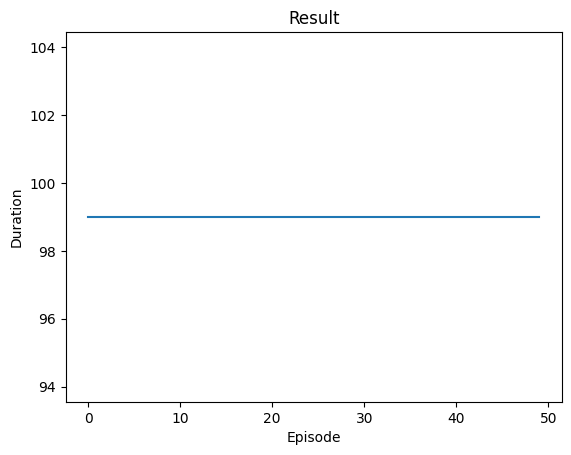

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [25]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and obtain state
    state, info = env.reset()
    # torch.unsqueeze(input, dim) → Tensor 
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        # Tensor.item() returns the value of this tensor as a standard Python number.
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)  # Loads a model’s parameter dictionary using a deserialized state_dict.

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# env.save_for_render(dir="render_logs")
# renderer = Renderer(render_logs_dir="render_logs")
# renderer.run()

## Summary and Conclusion
- The code is not sufficiently customized for the Gymnasium trading environment. While you may be able to see the portfolio return percentages during the training process, the code isn't able to capture an aggregate result of the training.
- 